In [1]:
import torch
import os

os.chdir('../')

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from itertools import chain
from rdkit.Chem import Descriptors
from src.tacogfn.utils import misc, molecules, sascore

Get generated results

In [3]:
ref_fps = misc.get_reference_fps()

In [4]:
pocket2mol_res = torch.load('misc/benchmarking/pocket2mol_res.pt')
targetdiff_res = torch.load('misc/benchmarking/targetdiff_res.pt')

In [8]:
pharmaco_res_path = 'misc/evaluations/20240124_0.75_zinc-mo-256_evaluated.json'
with open(pharmaco_res_path) as f:
    pharmaco_res = json.load(f)

Compute diversity

In [27]:
def compute_metrics(res):
    benchmark_eval = {}

    for pocket, val in tqdm(res.items()):
        smiles = val["smiles"]

        mols = [Chem.MolFromSmiles(smi) for smi in smiles]
        n_nones = len([mol for mol in mols if mol is None])
        if n_nones > 0:
            print(f"{n_nones} molecules could not be parsed")
        
        mols = [mol for mol in mols if mol is not None]

        qeds = [Descriptors.qed(mol) for mol in mols]
        sas = [(10.0 - sascore.calculateScore(mol)) / 9 for mol in mols]
        diversity = molecules.compute_diversity(mols)
        novelty = molecules.compute_novelty(mols, ref_fps)

        benchmark_eval[pocket] = {
            "smiles": smiles,
            "qeds": qeds,
            "sas": sas,
            "diversity": diversity,
            "novelty": novelty,
        }
    return benchmark_eval

In [9]:
# pocket2mol_eval = compute_metrics(pocket2mol_res)

In [8]:
targetdiff_eval = compute_metrics(targetdiff_res)

100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


In [9]:
compute_novelty = lambda metrics : list(chain.from_iterable([v["novelty"] for k, v in metrics.items()]))
compute_diversity = lambda metrics : list(chain.from_iterable([v["diversity"] for k, v in metrics.items()]))

In [12]:
pocket2mol_novelty = compute_novelty(pocket2mol_eval)
targetdiff_novelty = compute_novelty(targetdiff_eval)
pharmacogfn_novelty = compute_novelty(pharmaco_res)

print(f"Pocket2Mol Novelty: {np.mean(pocket2mol_novelty), np.median(pocket2mol_novelty)}")
print(f"TargetDiff Novelty: {np.mean(targetdiff_novelty), np.median(targetdiff_novelty)}")
print(f"PharmacoGFN Novelty: {np.mean(pharmacogfn_novelty), np.median(pharmacogfn_novelty)}")

Pocket2Mol Novelty: (0.45523859771851155, 0.4812707098835389)
TargetDiff Novelty: (0.4872655609643206, 0.4983498349834984)
PharmacoGFN Novelty: (0.5355816519936092, 0.5407056533117727)


In [10]:
pharmacogfn_diversity = compute_diversity(pharmaco_res)
print(f"PharmacoGFN Diversity: {np.mean(pharmacogfn_diversity), np.median(pharmacogfn_diversity)}")

NameError: name 'compute_diversity' is not defined

In [34]:
key_to_native_score = {
    key: v["native_docking_score"] for key, v in pharmaco_res.items()
}

In [45]:
key_to_native_score 

no_none = {k: v for k, v in key_to_native_score.items() if v is not None}

ranked_keys = sorted(no_none , key=no_none .get)

In [47]:
key_to_native_score[ranked_keys[0]]

-14.98382

In [48]:
key_to_native_score[ranked_keys[1]]

-13.94111

In [57]:
[0 for k in ranked_keys if '4h3c' in k]

[0]

In [49]:
key_to_native_score[ranked_keys[50]]

-5.6421

In [54]:
key_to_native_score[ranked_keys[90]]

-2.79147

In [21]:
# generate one conformer per molecule

AllChem.EmbedMolecule(mols[])

[13:37:18] Molecule does not have explicit Hs. Consider calling AddHs()


0

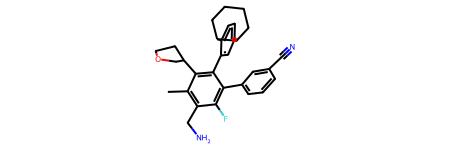

In [23]:
mols[1]

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


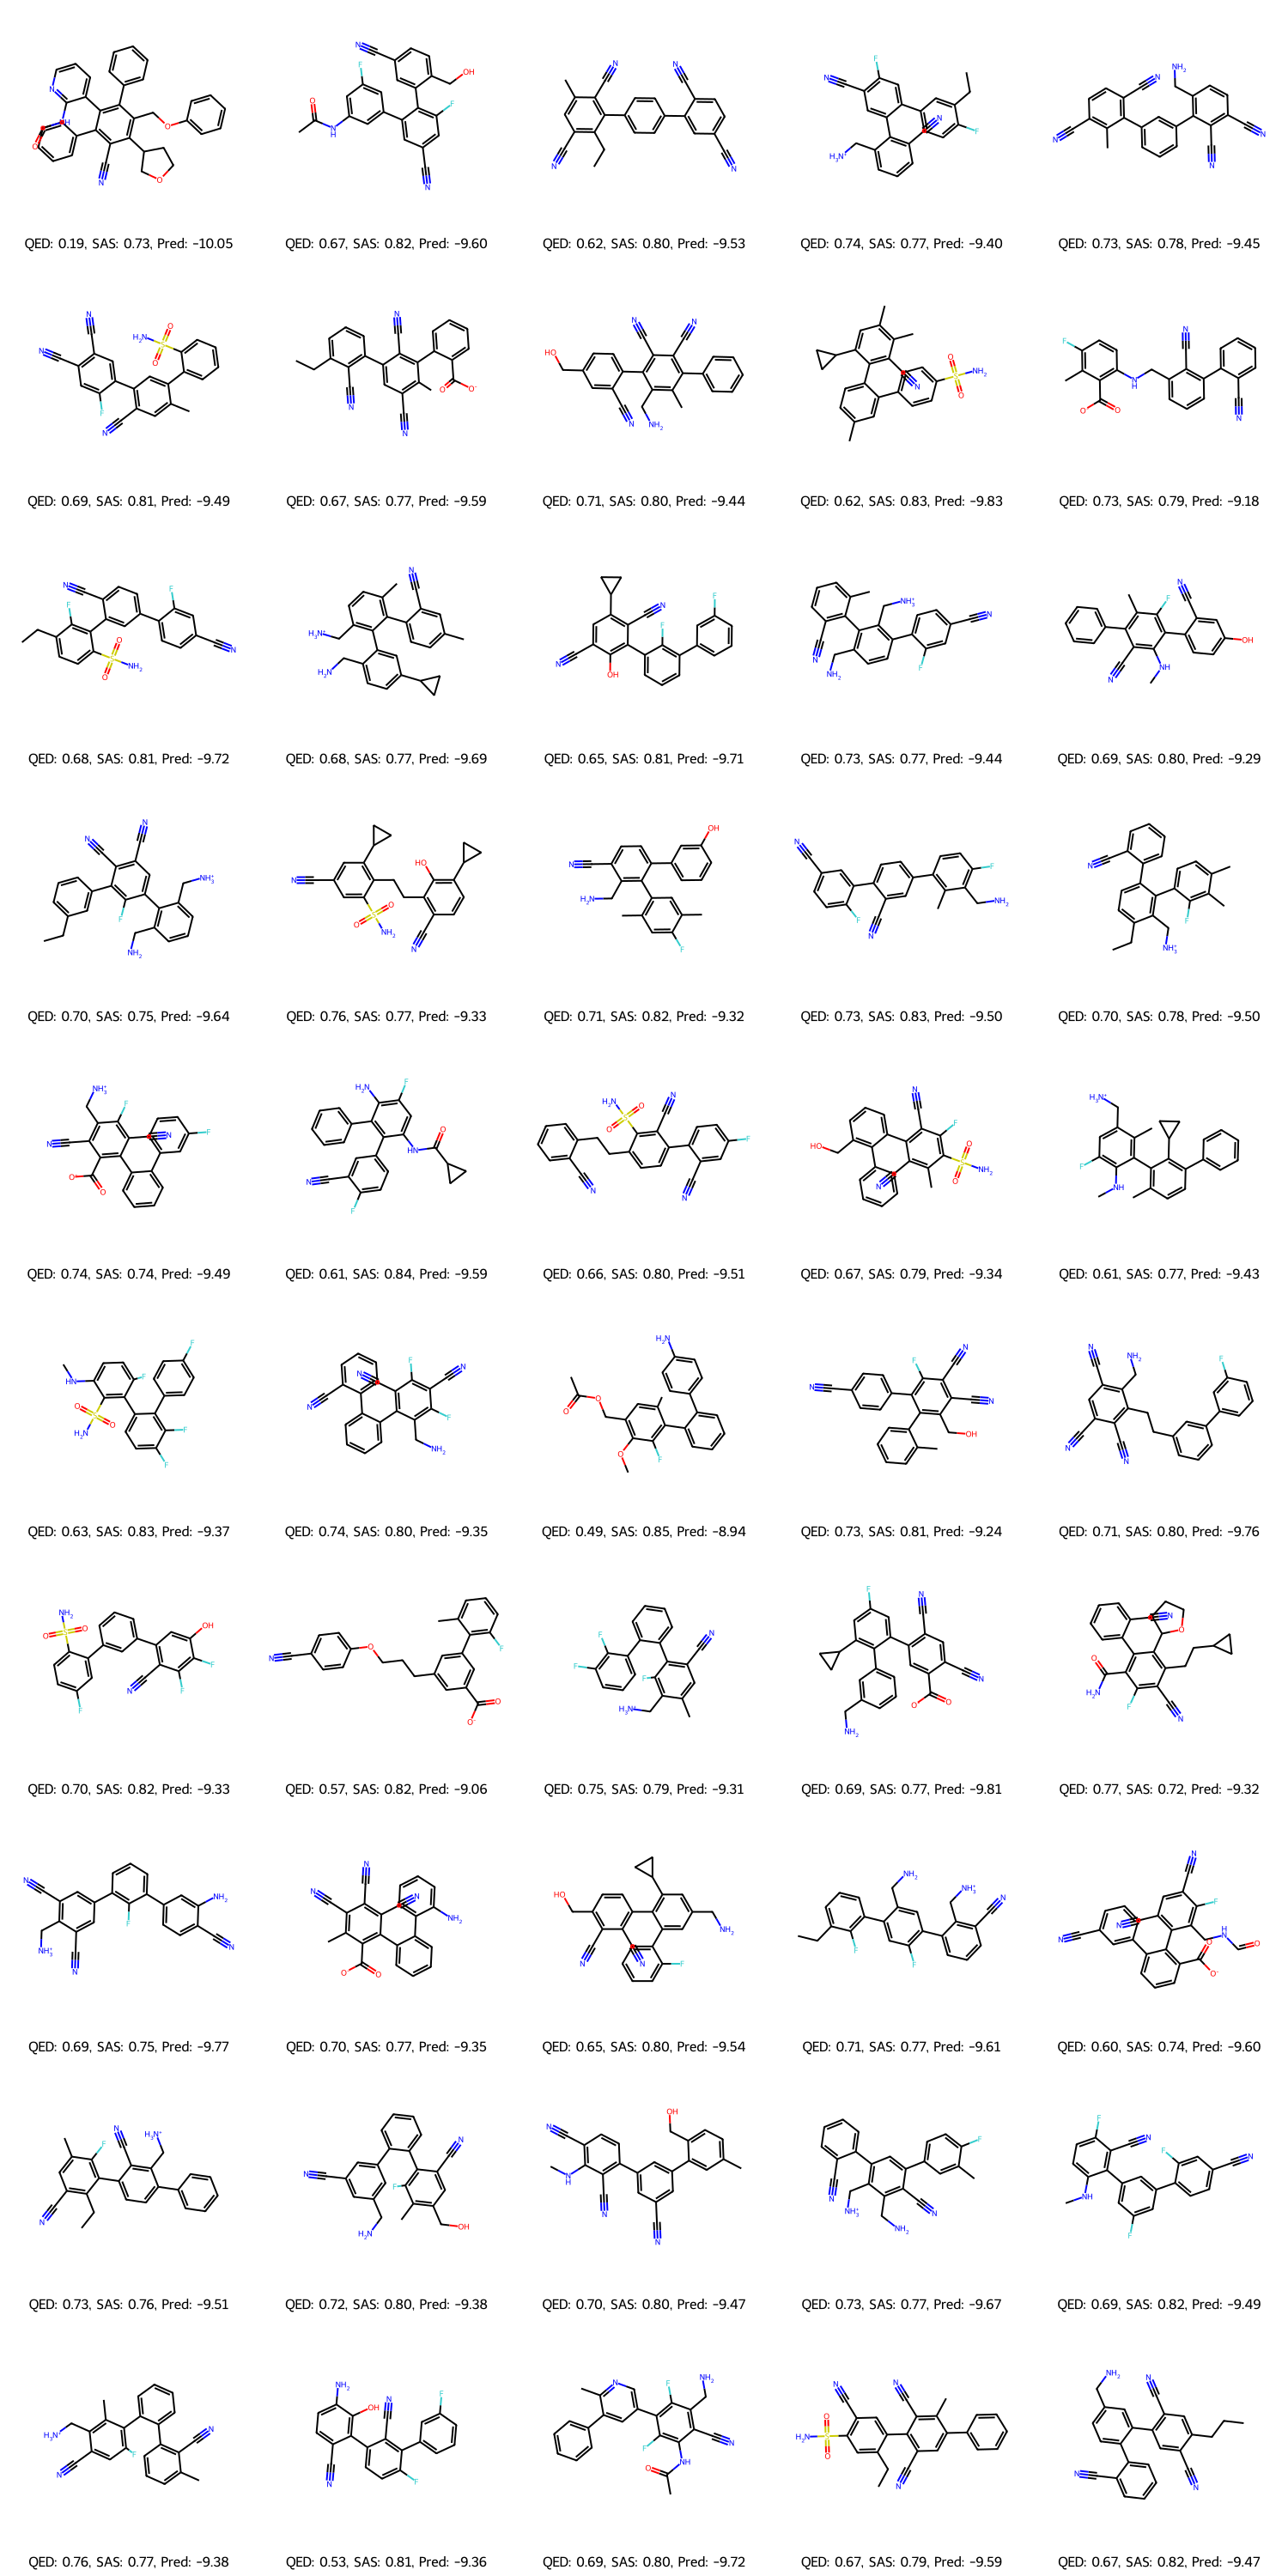

In [36]:
from rdkit.Chem import Draw

mols = [Chem.MolFromSmiles(s) for s in pharmaco_res['3b6h_A']['smiles']]
preds = [s for s in pharmaco_res['3b6h_A']['preds']]
qeds = [Descriptors.qed(mol) for mol in mols]
sas = [(10.0 - sascore.calculateScore(mol)) / 9 for mol in mols]

Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300, 300), legends=[f"QED: {qed:.2f}, SAS: {sa:.2f}, Pred: {pred:.2f}" for qed, sa, pred in zip(qeds, sas, preds)])

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


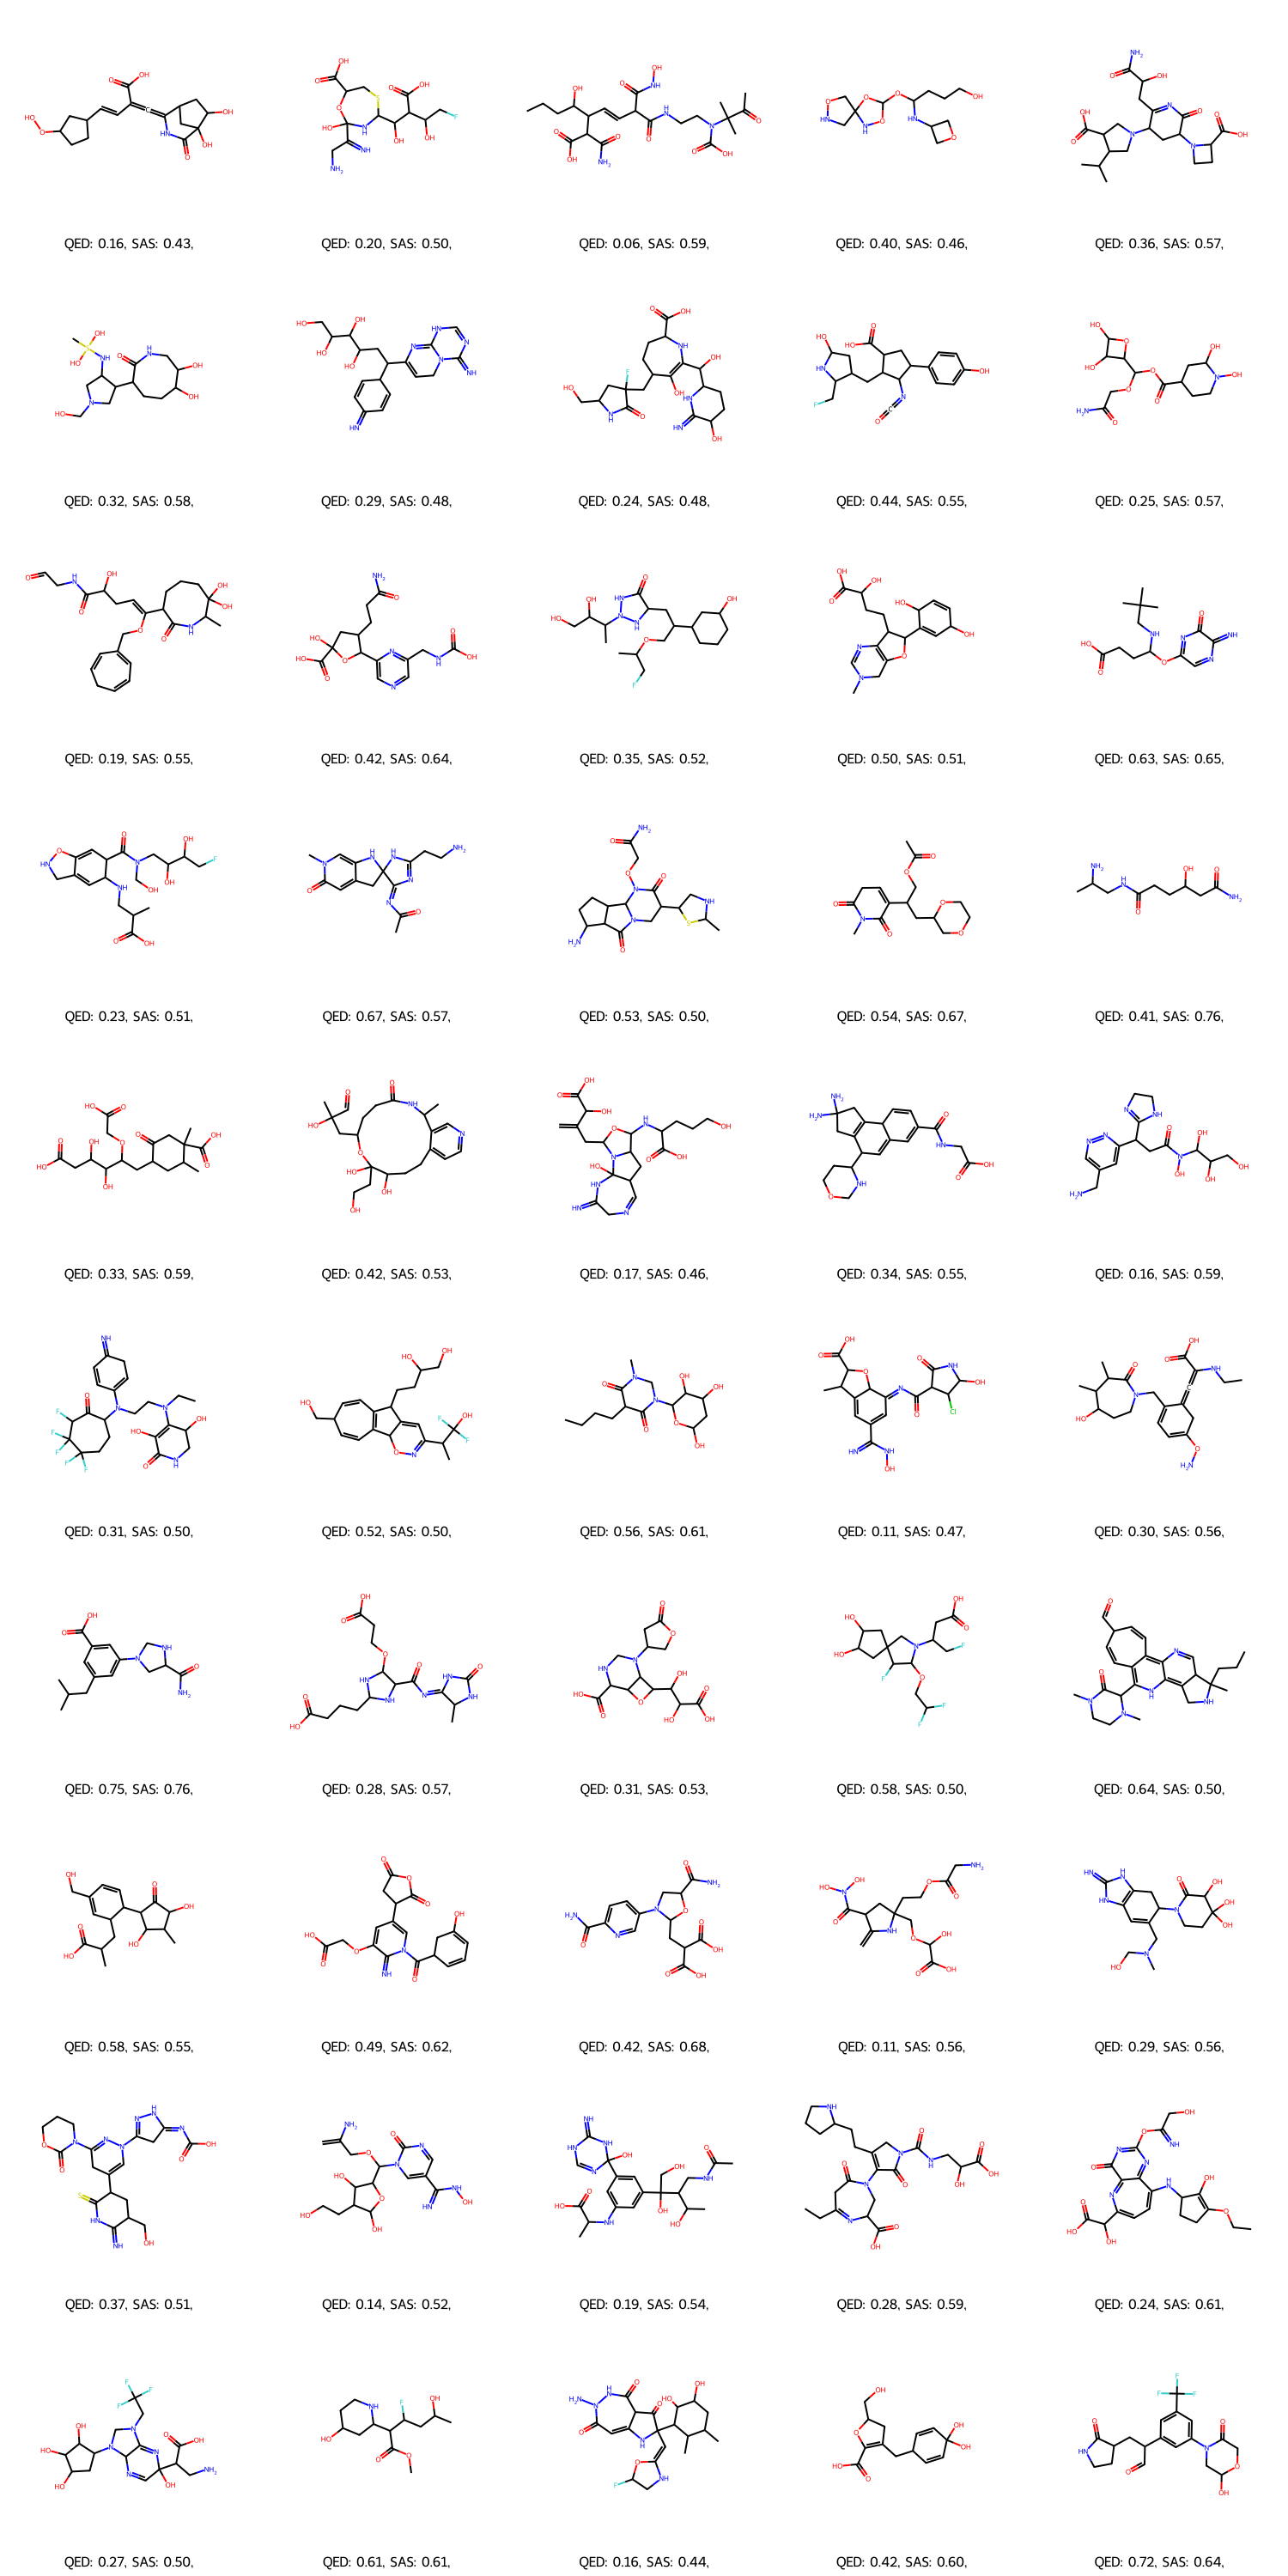

In [42]:
r = targetdiff_res
i = 0

mols = [Chem.MolFromSmiles(s) for s in r[i]['smiles']]
# preds = [s for s in r[0]['preds']]
qeds = [Descriptors.qed(mol) for mol in mols]
sas = [(10.0 - sascore.calculateScore(mol)) / 9 for mol in mols]

Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300, 300), legends=[f"QED: {qed:.2f}, SAS: {sa:.2f}," for qed, sa in zip(qeds, sas)])

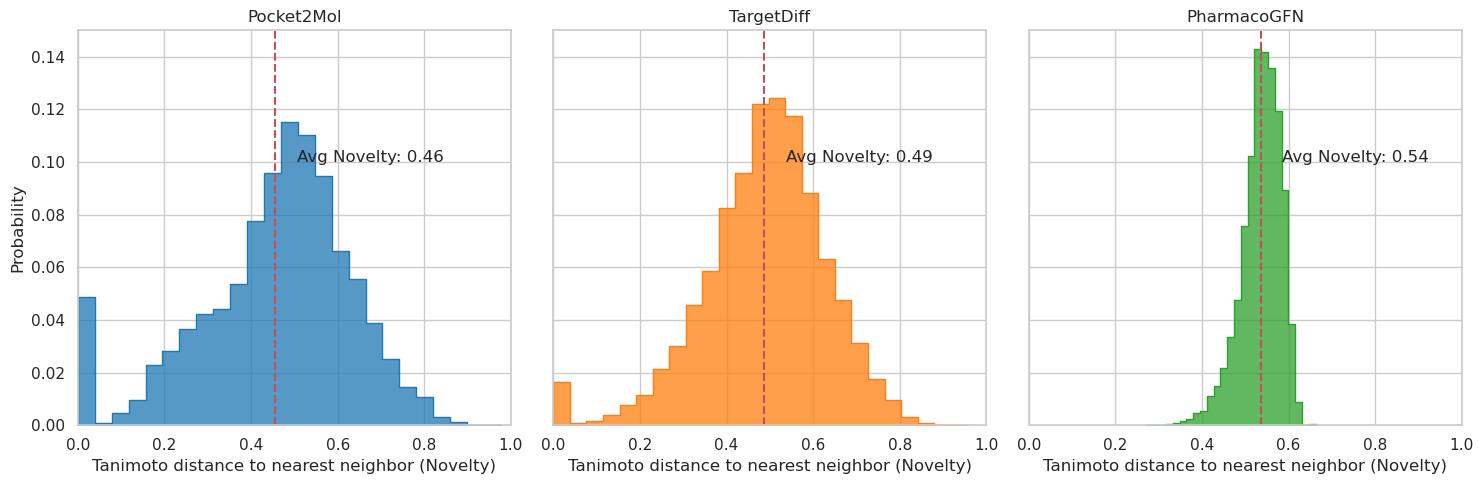

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# create a dictionary to map categories to labels
category_labels = {'Pocket2Mol': 'Pocket2Mol', 'PharmacoGFN': 'PharmacoGFN', 'TargetDiff': 'TargetDiff'}

data = pd.DataFrame({
    'Method': ['Pocket2Mol'] * len(pocket2mol_novelty) + ['TargetDiff'] * len(targetdiff_novelty) + ['PharmacoGFN'] * len(pharmacogfn_novelty),
    'Novelty': pocket2mol_novelty + targetdiff_novelty + pharmacogfn_novelty,
})

sns.set_theme(style="whitegrid")

# Define a custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, method in enumerate(['Pocket2Mol', 'TargetDiff', 'PharmacoGFN']):
    ax = axes[i]
    method_data = data[data['Method'] == method]
    ax = sns.histplot(x="Novelty", data=method_data, stat='probability', ax=ax, bins=25, color=custom_palette[i], element='step')
    ax.set_xlabel('Tanimoto distance to nearest neighbor (Novelty)')
    ax.set_ylabel('Probability')
    ax.set_title(method)
    ax.set_xlim(0, 1)
    
    # Calculate the mean value for the method
    mean_value = method_data['Novelty'].mean()
    
    # Draw vertical line at the mean value and write the mean value on the plot
    ax.axvline(mean_value, color='r', linestyle='--', label=f'Mean ({method})')
    ax.annotate(f'Avg Novelty: {mean_value:.2f}', xy=(mean_value, 0.1), xytext=(mean_value + 0.05, 0.1))

plt.tight_layout()
plt.show()


In [13]:
import seaborn as sns

# create a dictionary to map categories to labels
category_labels = {'Benchmark': 'Benchmark', 'Pharmaco': 'Pharmaco'}

data = pd.DataFrame({
    'Method': ['Pocket2Mol'] * len(benchmark_diversity) + ['PharmacoGFN'] * len(pharmaco_diversity),
    'Diversity': benchmark_diversity + pharmaco_diversity,
})

PharmacoGFN mean: 0.73
Pocket2Mol mean: 0.75


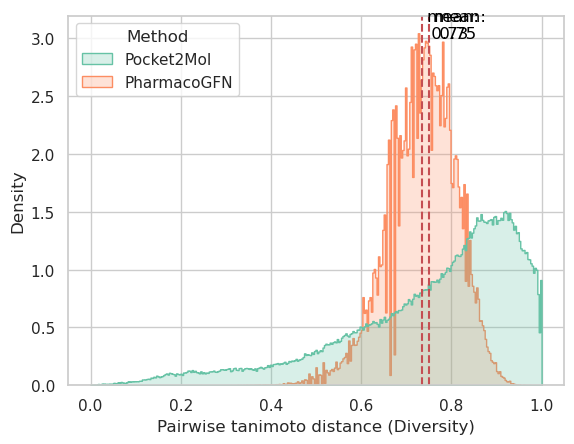

In [14]:
sns.set_theme(style="whitegrid")

ax = sns.histplot(x="Diversity", hue="Method", data=data, palette="Set2", element="step", stat='density')
ax.set_xlabel('Pairwise tanimoto distance (Diversity)')
ax.set_ylabel('Density')

# Calculate the mean values for each group
mean_values = data.groupby('Method')['Diversity'].mean()

# Draw vertical lines at the mean values and write the mean value on the plot
for method, mean in mean_values.items():
    ax.axvline(mean, color='r', linestyle='--', label=f'Mean ({method})')
    ax.annotate(f'mean:\n {mean:.2f}', xy=(mean, 0.5), xytext=(mean + 0.01, 3), color='black')
    print(f'{method} mean: {mean:.2f}')


In [16]:
# np.mean(all_vals['novelty'])

In [17]:
# all_vals['novelty'].index(np.min(all_vals['novelty']))

In [32]:
len(evaluated_results[11]['smiles'])

NameError: name 'evaluated_results' is not defined

In [13]:
import numpy as np
dock = False

all_vals = {
    'qeds': [],
    'sas': [],
    'diversity': [],
    'novelty': [],
}
if dock:
    all_vals['docking_scores'] = []


for key, val in benchmark_eval.items():
    all_vals['qeds'].append(np.mean(val['qeds']))
    all_vals['sas'].append(np.mean(val['sas']))
    all_vals['diversity'].append(np.mean(val['diversity']))
    all_vals['novelty'].append(np.mean(val['novelty']))
    if dock:
        all_vals['docking_scores'].extend([v for v in val['docking_scores'] if v < 0])

In [14]:
import numpy as np
for key, val in all_vals.items():
    print(key, np.mean(val), np.median(val))

qeds 0.5643521763341997 0.5754560084755495
sas 0.7506811622943664 0.7595498695643985
diversity 0.7423542547925785 0.7748222413765954
novelty 0.4509861315074474 0.4639609831490686


(8.47, 6.0)